# Contents

* Probability distributions seems to discern a bit. 
* There are some small overlapings could be due to the number of topics choseen .
* Not sure whether word embedings can perform well on our "two short" sentences. 
* Looking at the topics seem common words appear across al topics and just one or two differ

# Setup

In [1]:
import re
from collections import Counter
import pandas as pd
import numpy as np
import gensim
from gensim.models.ldamulticore import LdaMulticore
import nltk
import matplotlib.pyplot as plt

# Raw dataset

In [2]:
data = pd.read_csv('../../data/processed/cleanedDataV2.csv')

In [3]:
data.head()

,textID,text,sentiment
0,cb774db0d1,"['respond', 'go']",neutral
1,549e992a42,"['sad', 'miss']",negative
2,088c60f138,"['boss', 'bully']",negative
3,9642c003ef,"['interview', 'leave', 'alone']",negative
4,358bd9e861,"['son', 'put', 'release', 'already', 'buy']",negative


In [4]:
data = data.dropna().reset_index()

In [5]:
data.isnull().sum()

index        0
textID       0
text         0
sentiment    0
dtype: int64

# Parse data

In [6]:
#Convert list of tokens to string
list_corpus = []
for sentence in data['text']:
    tokens = sentence.replace("[","").replace("]","").replace("'","").replace(",","")
    list_corpus.append(tokens)
data['text'] = list_corpus

In [7]:
data['text'] = data.text.apply(lambda x: x.split(' '))

## Vectorize words

In [8]:
dictionary = gensim.corpora.Dictionary(data['text'])
print(dictionary)

Dictionary(9652 unique tokens: ['go', 'respond', 'miss', 'sad', 'boss']...)


In [9]:
dictionary.filter_extremes(no_above=0.8, no_below=3)
dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 4116 words.


In [10]:
#Make a BOW for every document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.text))
    
document_to_bow(data)

## LDA (training)

In [11]:
%%time
num_topics = 100
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=data.bow,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=2000,
                        passes=7,
                        alpha='asymmetric')

Wall time: 1min 14s


# LDA topic inspection

In [12]:
def document_to_lda_features(lda_model, document):
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

data['lda_features'] = list(map(
    lambda doc: document_to_lda_features(LDAmodel, doc),
    data.bow))

## Topics distribution

In [13]:
pos_topic_distribution = data.loc[data.sentiment == 'positive', 'lda_features'].mean()
neg_topic_distribution = data.loc[data.sentiment == 'negative', 'lda_features'].mean()
neu_topic_distribution = data.loc[data.sentiment == 'neutral', 'lda_features'].mean()

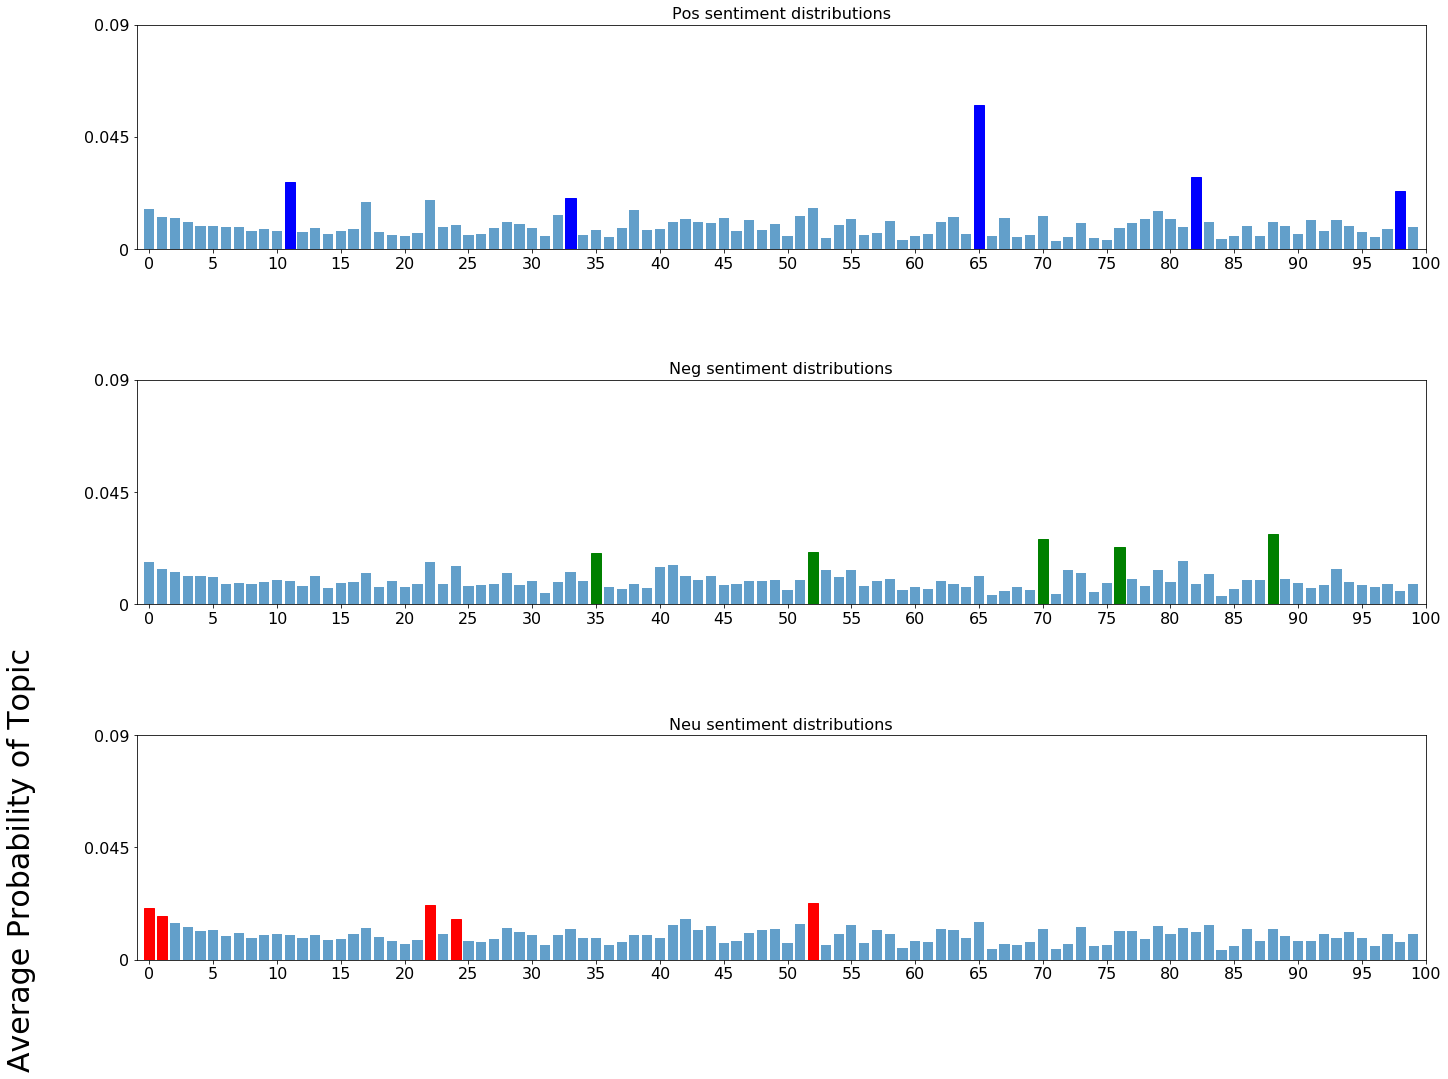

In [14]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(20,15))

nr_top_bars = 5

ax1.set_title("Pos sentiment distributions", fontsize=16)
ax2.set_title("Neg sentiment distributions", fontsize=16)
ax3.set_title("Neu sentiment distributions", fontsize=16)
ax3.text(-10, 0.04, "Average Probability of Topic", fontsize=30, ha="center", va="center",
         rotation="vertical")

for ax, distribution, color in zip([ax1,ax2,ax3],
                                   [pos_topic_distribution,neg_topic_distribution,neu_topic_distribution],
                                   ['b','g','r']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, 50)
    ax.set_xticks(range(0,101,5))
    ax.set_xticklabels(range(0,101,5), fontsize=16)
    ax.set_ylim(0,0.09)
    ax.set_yticks([0,0.045,0.09])
    ax.set_yticklabels([0,0.045,0.09], fontsize=16)

fig.tight_layout(h_pad=3.)


# Printing topics found

In [15]:
for i,topic in LDAmodel.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.072*"get" + 0.022*"love" + 0.017*"fire" + 0.014*"time" + 0.014*"like" + 0.013*"go" + 0.013*"think" + 0.012*"cooky" + 0.012*"tree" + 0.012*"awe"

1: 0.045*"not" + 0.027*"get" + 0.026*"wheres" + 0.023*"marry" + 0.019*"lately" + 0.016*"offer" + 0.014*"still" + 0.013*"hr" + 0.012*"love" + 0.012*"geek"

2: 0.033*"think" + 0.025*"vacation" + 0.020*"blast" + 0.019*"wit" + 0.017*"shout" + 0.014*"idiot" + 0.013*"bay" + 0.013*"official" + 0.012*"not" + 0.012*"conference"

3: 0.048*"english" + 0.026*"get" + 0.020*"well" + 0.019*"like" + 0.019*"pleasure" + 0.018*"migraine" + 0.018*"fabulous" + 0.016*"within" + 0.016*"smart" + 0.015*"hurry"

4: 0.045*"burn" + 0.028*"not" + 0.022*"bathroom" + 0.021*"bio" + 0.019*"attack" + 0.019*"fancy" + 0.019*"ace" + 0.018*"angry" + 0.016*"prefer" + 0.016*"science"

5: 0.040*"low" + 0.034*"french" + 0.031*"jay" + 0.031*"sexy" + 0.027*"sunburn" + 0.026*"not" + 0.025*"access" + 0.025*"slightly" + 0.022*"like" + 0.020*"lack"

6: 0.052*"etc" + 0.047*"congratulati